In [83]:
# Part 1, create a choropleth map of Georgia
import geopandas as gpd
import matplotlib.pyplot as plt
import requests

In [84]:
gdf = gpd.read_file("data/cb_2018_us_county_500k").to_crs("ESRI:102003") # albers contiguous USA
# just georgia
ga_gdf = gdf[gdf.STATEFP=="13"].copy()
# let's also add the centroid of each state
# we need the center of each county
ga_gdf['center'] = ga_gdf.geometry.centroid.to_crs("WGS84") # I wanted lat/lng, but it was giving me a warning that technically it's not valid to find the centroid of lat/lng
ga_gdf['lng'] = ga_gdf.center.x
ga_gdf['lat'] = ga_gdf.center.y
# and separate into lat/lng
ga_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,center,lng,lat
70,13,009,00345255,0500000US13009,13009,Baldwin,06,670027544,24802965,"POLYGON ((1161572.680 -406143.960, 1161735.025...",POINT (-83.24954 33.06926),-83.249535,33.069264
71,13,027,00345518,0500000US13027,13027,Brooks,06,1277108810,12188222,"MULTIPOLYGON (((1207326.103 -685822.710, 12074...",POINT (-83.58019 30.84191),-83.580185,30.841907
72,13,103,00350219,0500000US13103,13103,Effingham,06,1240066122,10679265,"POLYGON ((1345606.661 -457953.279, 1345760.616...",POINT (-81.34129 32.36721),-81.341291,32.367206
73,13,121,01694833,0500000US13121,13121,Fulton,06,1364248547,19674940,"POLYGON ((1026472.200 -385908.527, 1026912.936...",POINT (-84.46763 33.78996),-84.467626,33.789957
74,13,141,00348209,0500000US13141,13141,Hancock,06,1220058034,17479744,"POLYGON ((1175359.397 -403330.532, 1175377.631...",POINT (-83.00073 33.27042),-83.000730,33.270418


In [85]:
# now let's use open-meteo to get the temperature for each location
def get_forecasted_temperature(lats,lngs):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": list(lats),
        "longitude": list(lngs),
        "daily": "temperature_2m_max",
        "past_days":0
    }
    res = requests.post(url,data=params)
    data = res.json()
    print(data[0]['daily']['temperature_2m_max'][0])
    return [x['daily']['temperature_2m_max'][0] for x in data]

ga_gdf['temperature_c'] = get_forecasted_temperature(ga_gdf.lat,ga_gdf.lng)
ga_gdf.head()


26.9


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,center,lng,lat,temperature_c
70,13,009,00345255,0500000US13009,13009,Baldwin,06,670027544,24802965,"POLYGON ((1161572.680 -406143.960, 1161735.025...",POINT (-83.24954 33.06926),-83.249535,33.069264,26.9
71,13,027,00345518,0500000US13027,13027,Brooks,06,1277108810,12188222,"MULTIPOLYGON (((1207326.103 -685822.710, 12074...",POINT (-83.58019 30.84191),-83.580185,30.841907,26.3
72,13,103,00350219,0500000US13103,13103,Effingham,06,1240066122,10679265,"POLYGON ((1345606.661 -457953.279, 1345760.616...",POINT (-81.34129 32.36721),-81.341291,32.367206,27.8
73,13,121,01694833,0500000US13121,13121,Fulton,06,1364248547,19674940,"POLYGON ((1026472.200 -385908.527, 1026912.936...",POINT (-84.46763 33.78996),-84.467626,33.789957,27.7
74,13,141,00348209,0500000US13141,13141,Hancock,06,1220058034,17479744,"POLYGON ((1175359.397 -403330.532, 1175377.631...",POINT (-83.00073 33.27042),-83.000730,33.270418,26.4


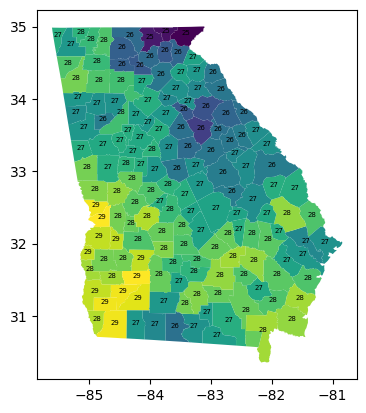

In [86]:
ga_gdf.to_crs("WGS84").plot(column="temperature_c")
for index,row in ga_gdf.iterrows():
    plt.text(row.lng,row.lat,f"{row.temperature_c:.0f}",fontsize=5, ha='center')
# and voila, look at that beautiful temperature plot